### Install The Library

In [1]:
!pip install -q transformers datasets scikit-learn matplotlib
!pip uninstall -y datasets transformers fsspec
!pip install datasets transformers fsspec --upgrade
!pip install wandb

Found existing installation: datasets 2.14.4
Uninstalling datasets-2.14.4:
  Successfully uninstalled datasets-2.14.4
Found existing installation: transformers 4.53.0
Uninstalling transformers-4.53.0:
  Successfully uninstalled transformers-4.53.0
Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but y

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Import The Library

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


### Loading The Dataset

In [5]:
from datasets import load_dataset
import os

os.environ["HF_DATASETS_OFFLINE"] = "0"
os.environ["TRANSFORMERS_OFFLINE"] = "0"

dataset = load_dataset("glue", "sst2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

📌 Sample training examples:
1. hide new secretions from the parental units  → Label: 0
2. contains no wit , only labored gags  → Label: 0
3. that loves its characters and communicates something rather beautiful about human nature  → Label: 1

📊 Number of samples:
Train → 67349 samples
Validation → 872 samples
Test → 1821 samples

📊 Label distribution in the training set:
       count
label       
0      29780
1      37569


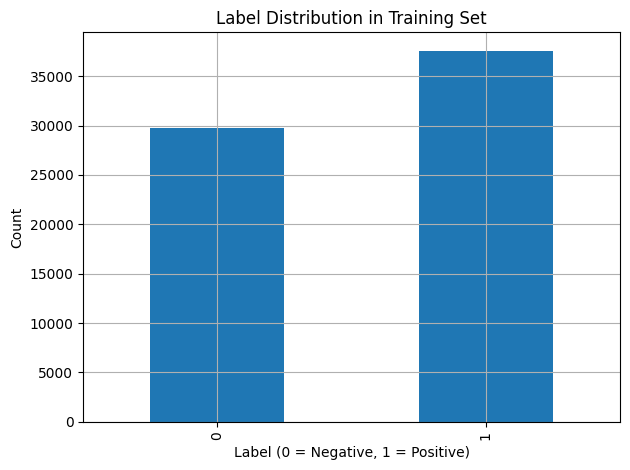

In [6]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Display sample training data
print("📌 Sample training examples:")
for i in range(3):
    print(f"{i+1}. {dataset['train'][i]['sentence']} → Label: {dataset['train'][i]['label']}")

# Display number of samples in each split
print("\n📊 Number of samples:")
for split in dataset.keys():
    print(f"{split.capitalize()} → {len(dataset[split])} samples")

# Count and display label distribution in the training set
label_counts = Counter(dataset['train']['label'])
labels_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count'])
labels_df.index.name = 'label'

print("\n📊 Label distribution in the training set:")
print(labels_df)

# Plot label distribution
labels_df.plot(kind='bar', legend=False, title='Label Distribution in Training Set')
plt.xlabel('Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


### Preparing  The Dataset

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(example):
    return tokenizer(example['sentence'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(tokenize, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
encoded_dataset = encoded_dataset.shuffle(seed=42)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

### Training a Transformer Model for Emotion Classification

In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
from collections import Counter
import torch

label_counter = Counter(dataset['train']['label'])
num_classes = len(label_counter)
total_samples = sum(label_counter.values())

class_weights = [total_samples / (num_classes * label_counter[i]) for i in range(num_classes)]
class_weights_tensor = torch.tensor(class_weights).to(device)


In [10]:
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss



In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

from transformers import TrainerCallback

class MetricsRecorder(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_acc = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append((state.global_step, logs["loss"]))
            if "eval_accuracy" in logs:
                self.eval_acc.append((state.epoch, logs["eval_accuracy"]))

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",          
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=8,        
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,        
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

recorder = MetricsRecorder()

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[recorder, EarlyStoppingCallback(early_stopping_patience=2)],  
)

trainer.train()




/tmp/ipython-input-11-8067506.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.198100,0.269129,0.916284,0.919337
2,0.119700,0.274788,0.922018,0.922197
3,0.099400,0.334766,0.923165,0.925473
4,0.047000,0.394366,0.917431,0.919463
5,0.010100,0.429826,0.923165,0.925307


TrainOutput(global_step=21050, training_loss=0.1062789432276173, metrics={'train_runtime': 7667.6021, 'train_samples_per_second': 43.918, 'train_steps_per_second': 2.745, 'total_flos': 2.21503330843008e+16, 'train_loss': 0.1062789432276173, 'epoch': 5.0})

### Save Model

In [12]:
save_path = "/content/drive/MyDrive/bert_models/sst2_model"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


('/content/drive/MyDrive/bert_models/sst2_model/tokenizer_config.json',
 '/content/drive/MyDrive/bert_models/sst2_model/special_tokens_map.json',
 '/content/drive/MyDrive/bert_models/sst2_model/vocab.txt',
 '/content/drive/MyDrive/bert_models/sst2_model/added_tokens.json')

### Model evaluation && Training

In [13]:
metrics = trainer.evaluate(encoded_dataset['validation'])
print(metrics)

{'eval_loss': 0.33476606011390686, 'eval_accuracy': 0.9231651376146789, 'eval_f1': 0.9254727474972191, 'eval_runtime': 5.7164, 'eval_samples_per_second': 152.544, 'eval_steps_per_second': 2.449, 'epoch': 5.0}


In [ ]:
preds = trainer.predict(encoded_dataset['validation'])
pred_labels = np.argmax(preds.predictions, axis=1)
true_labels = preds.label_ids

wrong_indices = np.where(pred_labels != true_labels)[0]

for idx in wrong_indices[:10]:
    print(f"Sentence: {dataset['validation'][int(idx)]['sentence']}")
    print(f"True Label: {true_labels[idx]} | Predicted: {pred_labels[idx]}")
    print("-" * 40)


Sentence: it takes a strange kind of laziness to waste the talents of robert forster , anne meara , eugene levy , and reginald veljohnson all in the same movie . 
True Label: 1 | Predicted: 0
----------------------------------------
Sentence: audrey tatou has a knack for picking roles that magnify her outrageous charm , and in this literate french comedy , she 's as morning-glory exuberant as she was in amélie . 
True Label: 0 | Predicted: 1
----------------------------------------
Sentence: i had to look away - this was god awful . 
True Label: 1 | Predicted: 0
----------------------------------------
Sentence: a sequence of ridiculous shoot - 'em - up scenes . 
True Label: 0 | Predicted: 1
----------------------------------------
Sentence: there 's ... tremendous energy from the cast , a sense of playfulness and excitement that seems appropriate . 
True Label: 1 | Predicted: 0
----------------------------------------
Sentence: the subtle strength of `` elling '' is that it never lose

### Educational charts

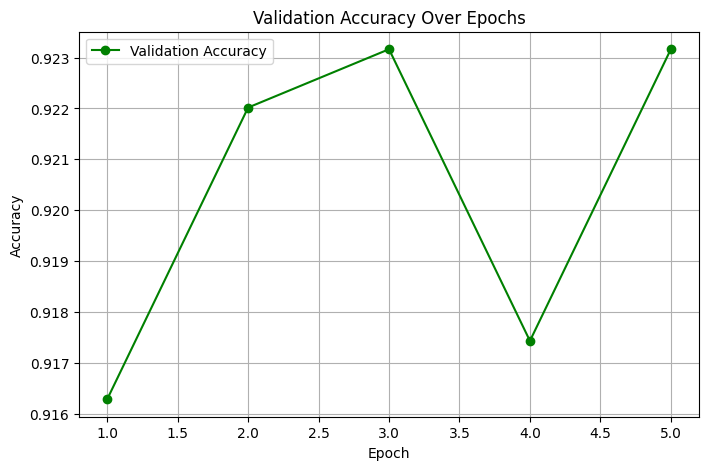

In [ ]:
unique_eval = dict(recorder.eval_acc)  
epochs, acc_values = zip(*sorted(unique_eval.items()))

plt.figure(figsize=(8, 5))
plt.plot(epochs, acc_values, marker='o', label="Validation Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.show()

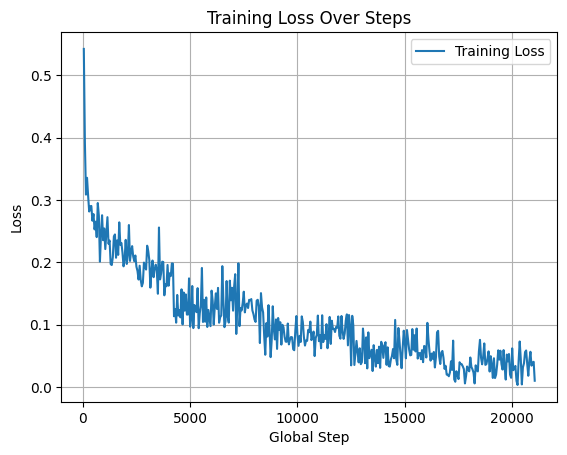

In [ ]:
steps = [s for s, _ in recorder.train_loss]
losses = [l for _, l in recorder.train_loss]

plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid(True)
plt.legend()
plt.show()